In [1]:
import argparse
import os
import pathlib
import sys
import numpy as np
import torch
import imageio
import bayes3d as b
from tqdm import tqdm
import pytorch3d.transforms
import jax.numpy as jnp
import nvdiffrast.torch as dr
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [2]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 1e-3
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = 128
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [3]:
def projection(x=0.1, n=1.0, f=50.0):
    return np.array([[n/x,    0,            0,              0],
                     [  0,  n/x,            0,              0],
                     [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                     [  0,    0,           -1,              0]]).astype(np.float32)
def translate(x, y, z):
    return np.array([[1, 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]]).astype(np.float32)
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()
mvp = torch.tensor(np.matmul(projection(x=0.4), translate(0, 0, 0.0)).astype(np.float32), device='cuda')

In [4]:
def quaternion_to_matrix(poses: torch.Tensor) -> torch.Tensor:
    """
    Convert rotations given as quaternions to rotation matrices.

    Args:
        quaternions: quaternions with real part first,
            as tensor of shape (..., 4).

    Returns:
        Rotation matrices as tensor of shape (..., 3, 3).
    """
    positions = poses[...,:3]
    quaternions = poses[...,3:]
    r, i, j, k = torch.unbind(quaternions, -1)
    x, y, z = torch.unbind(positions, -1)
    # pyre-fixme[58]: `/` is not supported for operand types `float` and `Tensor`.
    two_s = 2.0 / (quaternions * quaternions).sum(-1)

    o = torch.stack(
        (
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            x,
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            y,
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
            z,
            0.0 * x,
            0.0 * x,
            0.0 * x,
            0.0 * x + 1.0,
        ),
        -1,
    )
    rotation_matrices = o.reshape(quaternions.shape[:-1] + (4, 4))
    return rotation_matrices

# Transform vertex positions to clip space
def transform_pos(mtx, pos):
    t_mtx = torch.from_numpy(mtx).cuda() if isinstance(mtx, np.ndarray) else mtx
    # (x,y,z) -> (x,y,z,1)
    posw = torch.cat([pos, torch.ones([pos.shape[0], 1]).cuda()], axis=1)
    return torch.matmul(posw, t_mtx.t())[None, ...]

def render(glctx, mtx, pos, pos_idx, resolution: int):
    # Setup TF graph for reference.
    depth_ = pos[..., 2:3]
    depth = torch.tensor([[[(z_val/1)] for z_val in depth_.squeeze()]], dtype=torch.float32).cuda()
    pos_clip    = transform_pos(mtx, pos)
    rast_out, _ = dr.rasterize(glctx, pos_clip, pos_idx, resolution=[resolution, resolution])
    color   , _ = dr.interpolate(depth, rast_out, pos_idx)
    # color       = dr.antialias(color, rast_out, pos_clip, pos_idx)
    return color
    # return rast_out[:,:,:,2:3]


In [5]:
def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]
position = torch.tensor([0.0, 0.1, 0.2], device=device)
quat = torch.tensor([1.0, 0.1, 0.2, 0.3],device=device)
points = torch.zeros((5,3), device = device)
print(apply_transform(points, posevec_to_matrix(position, quat)))

tensor([[0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000]], device='cuda:0')


In [10]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

# m = b.utils.make_cuboid_mesh(jnp.array([0.5, 0.5, 0.2]))

vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()
# print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))
print(pos_idx.shape, vtx_pos.shape, col_idx.shape, vtx_col.shape)
print(vtx_pos, vtx_col)

torch.Size([15728, 3]) torch.Size([16762, 3]) torch.Size([16762, 3]) torch.Size([1, 3])
tensor([[-0.4248, -0.2584, -0.3477],
        [-0.4334, -0.2500, -0.3395],
        [-0.4441, -0.2338, -0.3527],
        ...,
        [ 0.4904, -0.0145,  0.2256],
        [ 0.3056, -0.0512,  0.2582],
        [ 0.3417, -0.0483,  0.3824]], device='cuda:0') tensor([[1., 1., 1.]], device='cuda:0')


In [11]:
def render_wrapper(pos,quat):
    rast_target = render(glctx, torch.matmul(mvp, posevec_to_matrix(pos, quat)), vtx_pos, pos_idx,  resolution)
    return rast_target

def get_viz(rast_target):
    img_target  = rast_target[0].detach().cpu().numpy()
    viz = b.get_depth_image(img_target[:,:,0]* 255.0)
    return viz

/var/tmp/ipykernel_218609/2544377672.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)


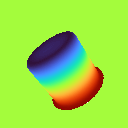

In [14]:
pos = torch.tensor([0.0, 0.0, -2.5],device=device)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)

ground_truth_image = render_wrapper(pos,quat)
viz_gt = get_viz(ground_truth_image)
viz_gt


In [ ]:
pos = torch.tensor([0.0, 0.0, -2.2],device=device, requires_grad=True)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)
rendered_image = render_wrapper(pos,quat)
viz = get_viz(rendered_image)
b.hstack_images([viz, viz_gt])


In [ ]:
optimizer = torch.optim.Adam([
    {'params': [pos], 'lr': 0.001, "name": "pos"},
    {'params': [quat], 'lr': 1.0, "name": "quat"},
], lr=0.0, eps=1e-15)
print(quat)

pbar = tqdm(range(100))
for _ in pbar:
    rendered_image =  render_wrapper(pos, quat)
    loss = torch.abs(ground_truth_image - rendered_image).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")
viz = get_viz(rendered_image)
print(quat)

b.hstack_images([viz, viz_gt])

In [ ]:
diff = (rast_opt - rast_target)**2 # L2 norm.
diff.sum()

In [ ]:
optimizer = torch.optim.Adam([pose_opt],  lr=0.00001)
images = []

for _ in tqdm(range(200)):    
    rast_opt = render(glctx, torch.matmul(mvp, quaternion_to_matrix(pose_opt)), vtx_pos, pos_idx,  resolution)

    diff = (rast_opt - rast_target)**2 # L2 norm.
    loss = torch.mean(diff)
    loss_val = float(loss)
    
    if (loss_val < loss_best) and (loss_val > 0.0):
        loss_best = loss_val
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss)    
    with torch.no_grad():
        pose_opt /= torch.sum(pose_opt**2)**0.5
    
    img_opt  = rast_opt[0].detach().cpu().numpy()
    images.append(
        b.hstack_images([
            b.get_depth_image(img_opt[:,:,0]* 255.0) ,
            b.get_depth_image(img_target[:,:,0]* 255.0) ,
        ])
    )

In [ ]:
b.vstack_images([images[0],images[-1]])